<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>

## Introduction

In this assignment, we explore, segment, and cluster the neighborhoods in the city of Toronto.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href='#item1'>Scrape the Wikipedia Page</a>


2. <a href='#item2'>Get the Latitude and Longitude</a>


3. <a href='#item3'>Explore and Cluster the Neighborhoods in Toronto</a>

    3.1. <a href='#item31'>Analyze Each Neighborhood</a>

    3.2 <a href='#item32'>Cluster Neighborhoods</a>

    3.3 <a href='#item33'>Examine Clusters</a>    

</font>
</div>

## Setup

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup
import requests
import json 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

## 1. Scrape the Wikipedia Page

Build code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M,  in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:

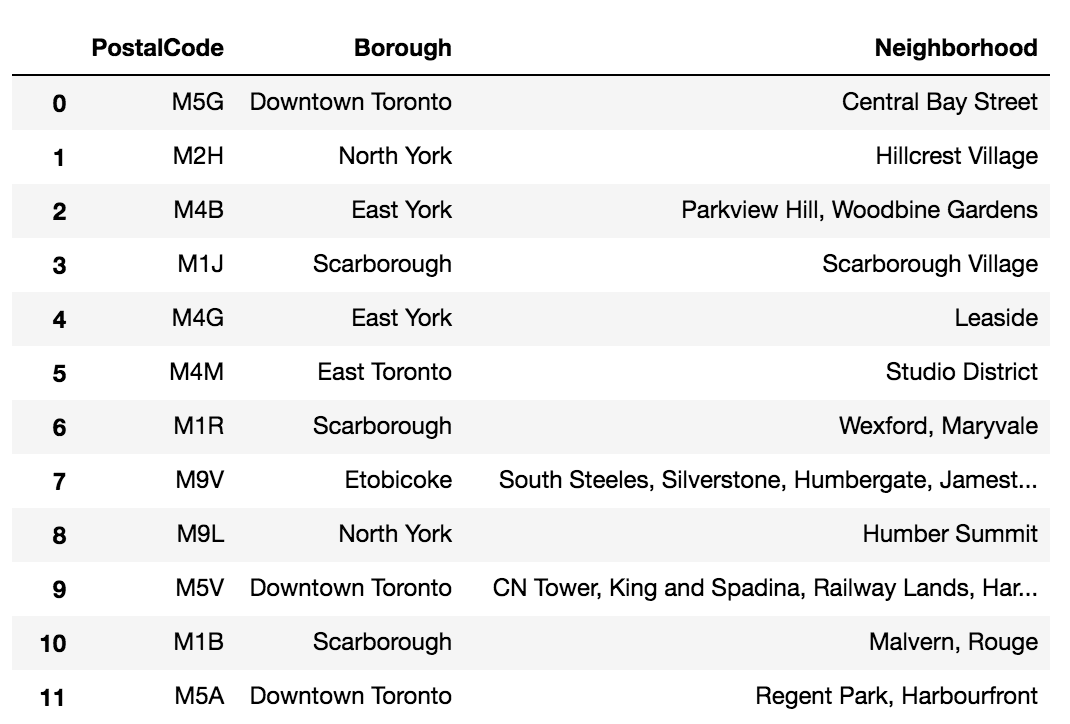

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [3]:
soup = BeautifulSoup(source, 'lxml')

In [4]:
table = soup.find('table', class_="wikitable sortable")

Get the table headers and store them in a `list`

In [5]:
headers = [col.text.rstrip() for col in table.find_all('th')]
headers

['Postcode', 'Borough', 'Neighbourhood']

Get the table data and store it in a `list`

In [6]:
items = [item.text.rstrip() for item in table.find_all('td')]
items[:12]

['M1A',
 'Not assigned',
 'Not assigned',
 'M2A',
 'Not assigned',
 'Not assigned',
 'M3A',
 'North York',
 'Parkwoods',
 'M4A',
 'North York',
 'Victoria Village']

### Wrangle and Clean the Data

In [7]:
toronto_data = pd.DataFrame(np.array(items).reshape(-1,3), columns=headers)

The dataframe will consist of three columns: *PostalCode, Borough, and Neighborhood*

In [8]:
toronto_data.rename(columns={'Postcode':'PostalCode', 'Neighbourhood':'Neighborhood'}, inplace=True)
print(toronto_data.shape)
toronto_data.head()

(288, 3)


,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


I only process the cells that have an assigned borough. Cells with a borough that is **Not assigned** were ignored.

In [9]:
toronto_data = toronto_data[toronto_data['Borough'] != 'Not assigned'].reset_index(drop=True)
print(toronto_data.shape)
toronto_data.head()

(211, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


If a cell has a Borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough. So for the **9th** cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be **Queen's Park**.

In [10]:
toronto_data[toronto_data['Neighborhood']=='Not assigned']

,PostalCode,Borough,Neighborhood
6,M7A,Queen's Park,Not assigned


In [11]:
toronto_data['Neighborhood'] = np.where(toronto_data.Neighborhood == 'Not assigned', toronto_data.Borough, toronto_data.Neighborhood)
toronto_data.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, I notice that **M5A** is listed twice and has two neighborhoods: **Harbourfront** and **Regent Park**. These two rows are combined into one row with the neighborhoods separated with a comma.

In [12]:
toronto_data[toronto_data.PostalCode=='M5A']

,PostalCode,Borough,Neighborhood
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park


I grouped the data by PostalCode and Borough

In [13]:
grp_data = toronto_data.groupby(['PostalCode', 'Borough'])
grp_data

For each group, we apply a `lambda` function to join the neighborhoods in the group and separate them by comma.

In [14]:
neighborhoods = grp_data['Neighborhood'].apply(lambda grp: ', '.join(grp)).reset_index()
neighborhoods.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [15]:
neighborhoods[neighborhoods.PostalCode=='M5A']

,PostalCode,Borough,Neighborhood
53,M5A,Downtown Toronto,"Harbourfront, Regent Park"


I use the `shape` method to print the number of rows of the dataframe.

In [16]:
neighborhoods.shape

(103, 3)

<a id='item2'></a>

## 2. Get the Latitude and Longitude

Now that I have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, I need to get the latitude and the longitude coordinates of each neighborhood.

I tried the following code part, but the Geocoder Python package was unreliable and couldn't get the geographical coordinates for the postal codes in Toronto. Therefore, I decided to proceed with the csv file instead.

In [17]:
!wget -q -O 'Geospatial_data.csv'  http://cocl.us/Geospatial_data
print('Geospatial Data downloaded!')

Geospatial Data downloaded!


In [18]:
geospatial_data = pd.read_csv('Geospatial_data.csv')
geospatial_data.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
print(geospatial_data.shape)
geospatial_data.head()

(103, 3)


,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [19]:
neighborhoods = neighborhoods.merge(geospatial_data, on='PostalCode')
neighborhoods.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [20]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()),neighborhoods.shape[0]))

The dataframe has 11 boroughs and 103 neighborhoods.


Use geopy library to get the latitude and longitude values of Toronto City

In [21]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

Solving environment: done

# All requested packages already installed.



In order to define an instance of the geocoder, we need to define a `user_agent`. We will name our agent *toronto_explorer*, as shown below.

In [22]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto City are 43.653963, -79.387207.


Create a map of Toronto with neighborhoods superimposed on top.

In [23]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'],
                                           neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

map_toronto

<a id='item3'></a>

## 3. Explore and Cluster the Neighborhoods in Toronto

I decided to work with only boroughs that contain the word Toronto.

In [24]:
neighborhoods_filtered = neighborhoods[neighborhoods.Borough.str.contains('Toronto')].reset_index(drop=True)
neighborhoods_filtered.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [25]:
neighborhoods_filtered.Borough.value_counts()

Downtown Toronto    18
Central Toronto      9
West Toronto         6
East Toronto         5
Name: Borough, dtype: int64

In [26]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [27]:
# create map of Toronto using latitude and longitude values
map_toronto_filtered = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_filtered['Latitude'], neighborhoods_filtered['Longitude'],
                                           neighborhoods_filtered['Borough'], neighborhoods_filtered['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_filtered)

map_toronto_filtered

Next, I am going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

<a id='item31'></a>
### 3.1 Analyze Each Neighborhood

#### Define Foursquare Credentials and Version

In [28]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20190503' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


In [29]:
# The code was removed by Watson Studio for sharing.

#### Let's explore the first neighborhood in our dataframe.

In [30]:
neighborhoods_filtered.loc[0, 'Neighborhood']

'The Beaches'

Get the neighborhood's latitude and longitude values.

In [31]:
neighborhood_latitude = neighborhoods_filtered.loc[0, 'Latitude']
neighborhood_longitude = neighborhoods_filtered.loc[0, 'Longitude']
neighborhood_name = neighborhoods_filtered.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, neighborhood_latitude, neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


Now, let's get the top **100 venues** that are in the first neighborhood within a radius of **500 meters**. First, let's create the GET request URL.

In [32]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                           CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude,
                                                                                                                           VERSION, radius, LIMIT)
#url

In [33]:
results = requests.get(url).json()

In [34]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [35]:
results['response']['groups'][0]['items'][1]

{'reasons': {'count': 0,
  'items': [{'reasonName': 'globalInteractionReason',
    'summary': 'This spot is popular',
    'type': 'general'}]},
 'referralId': 'e-0-4b8daea1f964a520480833e3-1',
 'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
     'suffix': '.png'},
    'id': '4bf58dd8d48988d11b941735',
    'name': 'Pub',
    'pluralName': 'Pubs',
    'primary': True,
    'shortName': 'Pub'}],
  'id': '4b8daea1f964a520480833e3',
  'location': {'address': '676 Kingston Rd.',
   'cc': 'CA',
   'city': 'Toronto',
   'country': 'Canada',
   'crossStreet': 'at Main St.',
   'distance': 460,
   'formattedAddress': ['676 Kingston Rd. (at Main St.)',
    'Toronto ON M4E 1R4',
    'Canada'],
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.679181434941015,
     'lng': -79.29721535878515}],
   'lat': 43.679181434941015,
   'lng': -79.29721535878515,
   'postalCode': 'M4E 1R4',
   'state': 'ON'},
  'name': 'Grover Pub and Grub',
  'pho

In [36]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
1,Grover Pub and Grub,Pub,43.679181,-79.297215
2,Guru Raghavendra Ji,Astrologer,43.680187,-79.292337
3,Upper Beaches,Neighborhood,43.680563,-79.292869


In [37]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
toronto_venues = getNearbyVenues(names=neighborhoods_filtered['Neighborhood'], latitudes=neighborhoods_filtered['Latitude'], longitudes=neighborhoods_filtered['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

Check the size of the resulting dataframe

In [40]:
print(toronto_venues.shape)
toronto_venues.head()

(1704, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Guru Raghavendra Ji,43.680187,-79.292337,Astrologer
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Let's check how many venues were returned for each neighborhood

In [41]:
toronto_venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
Adelaide, King, Richmond                                                                                      100
Berczy Park                                                                                                    56
Brockton, Exhibition Place, Parkdale Village                                                                   20
Business Reply Mail Processing Centre 969 Eastern                                                              20
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara     14
Cabbagetown, St. James Town                                                                                    47
Central Bay Street                                                                                             87
Chinatown, Grange Park, Kensington Market                                                                     100
Christie                                                                   

Let's find out how many unique categories can be curated from all the returned venues

In [42]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 240 uniques categories.


#### Explore Venues in each Neighborhood

In [43]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + [col for col in toronto_onehot.columns if col != 'Neighborhood']
fixed_columns

toronto_onehot = toronto_onehot[fixed_columns]
print(toronto_onehot.shape)
toronto_onehot.head()

(1704, 240)


,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [44]:
toronto_grp = toronto_onehot.groupby(['Neighborhood']).mean().reset_index()
print(toronto_grp.shape)
toronto_grp.head()

(38, 240)


,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,0.0,0.010000,0.01,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.000000,0.030000,0.0,0.04,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.01,0.000000,0.01,0.020000,0.00,0.0,0.03,0.01,0.0,0.00,0.050000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.020000,0.000000,0.060000,0.0,0.0,0.0,0.01,0.000000,0.00,0.020000,0.00,0.03,0.0,0.000000,0.0,0.01,0.01,0.01,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0

Let's print each neighborhood along with the top 5 most common venues

In [45]:
num_top_venues = 5

for hood in toronto_grp['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grp[toronto_grp['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2  American Restaurant  0.04
3                  Bar  0.04
4           Steakhouse  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2              Bakery  0.04
3         Cheese Shop  0.04
4  Seafood Restaurant  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0  Breakfast Spot  0.10
1     Coffee Shop  0.10
2            Café  0.10
3         Stadium  0.05
4      Restaurant  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.10
1         Yoga Studio  0.05
2                Park  0.05
3          Comic Shop  0.05
4    Recording Studio  0.05


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.21
1    Ai

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grp['Neighborhood']

for ind in np.arange(toronto_grp.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grp.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Thai Restaurant,American Restaurant,Steakhouse,Cosmetics Shop,Burger Joint,Hotel,Bakery
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Farmers Market,Cheese Shop,Seafood Restaurant,Beer Bar,Italian Restaurant,Bakery
2,"Brockton, Exhibition Place, Parkdale Village",Café,Breakfast Spot,Coffee Shop,Performing Arts Venue,Nightclub,Burrito Place,Stadium,Caribbean Restaurant,Bar,Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Comic Shop,Skate Park,Burrito Place,Butcher,Restaurant,Recording Studio,Pizza Place,Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Sculpture Garden,Plane,Harbor / Marina,Boutique,Airport Food Court,Airport


<a id='item32'></a>
### 3.2 Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [48]:
# set number of clusters
kclusters = 5

toronto_grp_clustering = toronto_grp.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grp_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [49]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods_filtered

# merge toronto grouped with toronto data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Astrologer,Health Food Store,Pub,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Park,Sandwich Place,Pizza Place,Brewery,Burger Joint,Burrito Place,Pub,Pet Store,Movie Theater,Sushi Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item33'></a>
### 3.3 Examine Clusters

#### Cluster 1

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Astrologer,Health Food Store,Pub,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
1,East Toronto,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
2,East Toronto,0,Park,Sandwich Place,Pizza Place,Brewery,Burger Joint,Burrito Place,Pub,Pet Store,Movie Theater,Sushi Restaurant
3,East Toronto,0,Café,Coffee Shop,Gastropub,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Brewery,Seafood Restaurant,Sandwich Place
5,Central Toronto,0,Food & Drink Shop,Hotel,Clothing Store,Dance Studio,Sandwich Place,Park,Dog Run,Grocery Store,Gym,Breakfast Spot
6,Central Toronto,0,Clothing Store,Coffee Shop,Yoga Studio,Bagel Shop,Park,Chinese Restaurant,Dessert Shop,Rental Car Location,Diner,Salon / Barbershop
7,Central Toronto,0,Pizza Place,Sandwich Place,Dessert Shop,Italian Restaurant,Sushi Restaurant,Coffee Shop,Café,Farmers Market,Brewery,Seafood Restaurant
9,Central Toronto,0,Coffee Shop,Pub,Bagel Shop,Fried Chicken Joint,Liquor Store,Pizza Place,Vietnamese Restaurant,Supermarket,Light Rail Station,American Restaurant
11,Downtown Toronto,0,Coffee Shop,Pet Store,Park,Restaurant,Market,Chinese Restaurant,Pub,Italian Restaurant,Café,Pizza Place
12,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Hotel,Gastropub,Fast Food Restaurant,Mediterranean Restaurant,Men's Store


#### Cluster 2

In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,1,Playground,Summer Camp,Fish Market,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


#### Cluster 3

In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,2,Park,Playground,Trail,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
23,Central Toronto,2,Trail,Jewelry Store,Park,Sushi Restaurant,Yoga Studio,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant


#### Cluster 4

In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,3,Home Service,Garden,Yoga Studio,Dog Run,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


#### Cluster 5

In [55]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,4,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


### Thank you for using this notebook!

This notebook was created by [Georgios Chatzis](https://www.linkedin.com/in/georgios-chatzis-01523293/). This notebook is part of the course on **Coursera** called *Applied Data Science Capstone*.